<a href="https://www.kaggle.com/code/aysegulsezen/timeseriesml?scriptVersionId=168683278" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        fileFullName=os.path.join(dirname, filename)
        if (filename=='train.csv'):
            train_data = pd.read_csv(fileFullName)
        elif (filename=='test.csv'):
            test_data = pd.read_csv(fileFullName)
        elif (filename=='holidays_events.csv'): 
            holidays_events_data = pd.read_csv(fileFullName)
        elif (filename=='oil.csv'): 
            oil_data = pd.read_csv(fileFullName)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


**-ANALYSING DATA-**

Firstly, we should understand data we have. Train data must be linked to holiday events and the "date" field. Again, "oil" must be linked to the "date" field. The onpromotion field in Train data shows how many promotions there are in that store, according to the project description.

We can look at how many stores there are in Train data, how many families (product groups), what dates there are and how much data there is in total with the following queries.

In [2]:
print('Count of train data:',len(train_data))
print('Families list:', train_data['family'].unique())
print('Stores list:', train_data['store_nbr'].unique())

Count of train data: 3000888
Families list: ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
Stores list: [ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]


Now, let's see how the holiday events effect sale amount. 

In [3]:
trainJoinEventData = pd.merge(train_data, holidays_events_data, how="left", on=["date"])
#print(trainJoinEventData)

# Every stores product groups daily avarage sale for comparing events day and promotion
print('---------------------------------------------------')
print("Daily avarage sale per store and family:")
print(trainJoinEventData.groupby(["family","store_nbr"])["sales"].mean())

# No events -Every stores product groups daily avarage sale 
print('---------------------------------------------------')
print("Daily avarage sale No event day per store and family:")
noEventTrainData=trainJoinEventData.query('locale_name != locale_name')
print(noEventTrainData.groupby(["family","store_nbr"])["sales"].mean())

---------------------------------------------------
Daily avarage sale per store and family:
family      store_nbr
AUTOMOTIVE  1             3.251459
            2             5.411902
            3             9.311552
            4             4.028588
            5             5.464411
                           ...    
SEAFOOD     50           23.686794
            51           65.851666
            52            0.720814
            53            3.921128
            54            1.735123
Name: sales, Length: 1782, dtype: float64
---------------------------------------------------
Daily avarage sale No event day per store and family:
family      store_nbr
AUTOMOTIVE  1             3.215782
            2             5.422486
            3             9.217877
            4             3.972067
            5             5.393156
                           ...    
SEAFOOD     50           23.489775
            51           65.979895
            52            0.708890
            53 

Let s choose 1 store and 1 product group and see how much it might have changed the average sales. How the Ambato event changed the store 1 sales average for the AUTOMOTIVE family group:

In [4]:
# product AUTOMOTIVE event Ambato rate  
AmbatoAutomotive = trainJoinEventData.query('family=="AUTOMOTIVE" and locale_name=="Ambato"  ') 
grpAmbatoAutomotive = AmbatoAutomotive.groupby(["store_nbr"])["sales"].mean().reset_index(name ='Ambato Avg Sale')
trainAutomotiveAvg= train_data.query('family=="AUTOMOTIVE"').groupby(["store_nbr"])["sales"].mean().reset_index(name ='Avg Sale')
print('---------------------------------------------------')
print('In Ambato event, Automotive family daily sales avarage per store:')
result = pd.merge(trainAutomotiveAvg, grpAmbatoAutomotive, on="store_nbr")
result['diff'] = result['Ambato Avg Sale'] - result['Avg Sale']
print(result)


---------------------------------------------------
In Ambato event, Automotive family daily sales avarage per store:
    store_nbr   Avg Sale  Ambato Avg Sale      diff
0           1   3.251188            3.625  0.373812
1           2   5.403800            6.500  1.096200
2           3   9.291568           10.000  0.708432
3           4   4.018409            4.750  0.731591
4           5   5.459620            6.000  0.540380
5           6   5.361045            3.625 -1.736045
6           7   4.245843            2.875 -1.370843
7           8   5.279097            7.000  1.720903
8           9  13.870546           11.875 -1.995546
9          10   3.083135            3.000 -0.083135
10         11   6.690024            7.750  1.059976
11         12   4.752969            5.125  0.372031
12         13   5.524347            6.375  0.850653
13         14   3.618171            3.625  0.006829
14         15   2.684086            3.125  0.440914
15         16   5.752969            5.375 -0.37796

Not only holiday events will affect sales, certain products may be sold more or less on certain dates. For this, let's look at the sales amounts for store number 1 and AUTOMOTIVE family on the days of the year:

store1AutoGrp:
     month  day  AvgSale  time
0        1    1     0.00     0
1        1    2     3.80     1
2        1    3     2.80     2
3        1    4     3.20     3
4        1    5     4.00     4
..     ...  ...      ...   ...
360     12   27     4.25   360
361     12   28     5.00   361
362     12   29     3.00   362
363     12   30     3.50   363
364     12   31     2.25   364

[365 rows x 4 columns]


/tmp/ipykernel_18/2243146755.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store1Auto['date'] = pd.to_datetime(store1Auto['date'])
/tmp/ipykernel_18/2243146755.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store1Auto['month'] = store1Auto['date'].dt.month
/tmp/ipykernel_18/2243146755.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

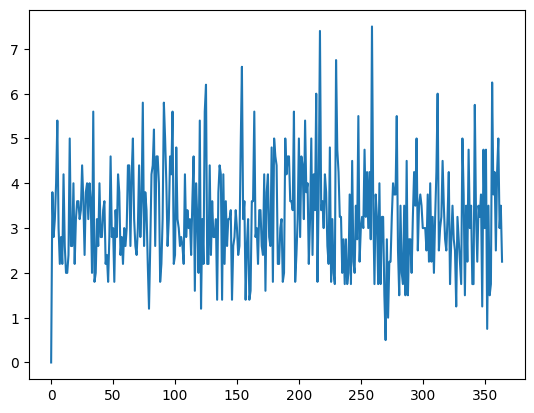

In [5]:
import matplotlib.pyplot as plt
store1Auto=train_data.query('family=="AUTOMOTIVE" and store_nbr==1') 

store1Auto['date'] = pd.to_datetime(store1Auto['date'])
store1Auto['month'] = store1Auto['date'].dt.month
store1Auto['day'] = store1Auto['date'].dt.day

#print(store1Auto)
store1AutoGrp = store1Auto.groupby(["month","day"])["sales"].mean().reset_index(name ='AvgSale')
store1AutoGrp['time'] = np.arange(len(store1AutoGrp.index))
print('store1AutoGrp:')
print(store1AutoGrp)

plt.plot(store1AutoGrp['time'],store1AutoGrp['AvgSale'])
plt.show()


The fields we will use for the Machine Learning algorithm, that is, the fields that should be in training data, should be month-day, onpromotion, oil and holiday event.
Oil and onpromotion show numerical fields and quantity. However, if we were to convert the holiday event field and each event into a numeric value, there would be values that the algorithm would not understand since it would be a category. In other words, each event should have a ratio of how much it increases or decreases average sales, and this should be used when making predictions. The link below was a guide for me on the subject.
https://www.southampton.ac.uk/passs/confidence_in_the_police/multivariate_analysis/simple_linear_regression_several_categories.page

To understand the subject better, I only selected the 'Manta' event and looked at its impact rate on average sales.

In [6]:
dateOfEvent1=holidays_events_data.query('locale_name=="Manta"')['date'] 
print('Manta event date:')
print(dateOfEvent1)
event1_bool=np.in1d(train_data['date'],dateOfEvent1)
event1 = np.array([int(i) for i in event1_bool]) 

train_data['Event1']=event1

print('Avarage sale amount of all store:',train_data['sales'].mean())
print('In Manta event dates, avarage sale amount of all store:',train_data.query('Event1== 1')['sales'].mean())

Manta event date:
0      2012-03-02
46     2013-03-02
93     2014-03-02
164    2015-03-02
214    2016-03-02
301    2017-03-02
Name: date, dtype: object
Avarage sale amount of all store: 357.77574911261894
In Manta event dates, avarage sale amount of all store: 390.12183953131307


I examined whether the coefficient value in Python's Linear regression package was similar to the ratio I found.

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train_data[['Event1','onpromotion']], train_data['sales'])

print('coef:',model.coef_)
print('.intercept:',model.intercept_)


coef: [40.41302685 38.59374412]
.intercept: 257.2051090382542


Event1 coefficient is 40.4130. This value must be the ratio we need. It is important to know how the Sklearn Linear Regression method works. I guess if we send this category field as 1/0 in the dataset, the method will automatically calculate this value within itself. The model.coef information is an indication of this.
Now let's prepare training and test dataset accordingly and see the result.

In [8]:
print(holidays_events_data)
events=holidays_events_data['locale_name'].unique()
i=1
for event in events:
    eventNo='event'+str(i)
    dateOfEvent=holidays_events_data.query('locale_name==@event')['date'] 
    event_bool=np.in1d(train_data['date'],dateOfEvent)
    eventCol = np.array([int(i) for i in event_bool]) 

    train_data[eventNo]=eventCol
    
    # for test data 
    event_boolTest=np.in1d(test_data['date'],dateOfEvent)
    eventColTest = np.array([int(i) for i in event_boolTest]) 
    test_data[eventNo]=eventColTest
    
    i=i+1

#print(train_data)
#print(test_data)

           date        type    locale locale_name  \
0    2012-03-02     Holiday     Local       Manta   
1    2012-04-01     Holiday  Regional    Cotopaxi   
2    2012-04-12     Holiday     Local      Cuenca   
3    2012-04-14     Holiday     Local    Libertad   
4    2012-04-21     Holiday     Local    Riobamba   
..          ...         ...       ...         ...   
345  2017-12-22  Additional  National     Ecuador   
346  2017-12-23  Additional  National     Ecuador   
347  2017-12-24  Additional  National     Ecuador   
348  2017-12-25     Holiday  National     Ecuador   
349  2017-12-26  Additional  National     Ecuador   

                       description  transferred  
0               Fundacion de Manta        False  
1    Provincializacion de Cotopaxi        False  
2              Fundacion de Cuenca        False  
3        Cantonizacion de Libertad        False  
4        Cantonizacion de Riobamba        False  
..                             ...          ...  
345          

In [9]:
#print(train_data.info())
#print(oil_data.info())
oil_data["date"] = pd.to_datetime(oil_data["date"])
train_data1=train_data
train_data1["date"] = pd.to_datetime(train_data1["date"])
train_data2 = train_data1.merge(oil_data, on='date', how='left')
#print(train_data2)
train_data2['dcoilwtico'] = train_data2['dcoilwtico'].fillna(0)

test_data1=test_data
test_data1["date"] = pd.to_datetime(test_data1["date"])
test_data2 = test_data1.merge(oil_data, on='date', how='left')
test_data2['dcoilwtico'] = test_data2['dcoilwtico'].fillna(0)



X_train=train_data2.drop(['id','date','store_nbr','family','sales','Event1'], axis=1)
X_train_arr = X_train.to_numpy()  #[:,1:26]
y_train=train_data2['sales']
y_train_arr = y_train.to_numpy()
print(X_train.shape)
#print('arr:')
#print( len(arr[1:])
print(X_train_arr.shape)
print(X_train_arr)

print('y_train shape:',y_train_arr.shape)
print(y_train_arr)
print(y_train)

X_test = test_data2.drop(['id','date','store_nbr','family'], axis=1)
X_test_arr = X_test.to_numpy()#[:,1:26]
print('Xtest_arr')
print('X_test_arr shape:',X_test_arr.shape)
print('X_test shape:',X_test.shape)





(3000888, 26)
(3000888, 26)
[[  0.     0.     0.   ...   0.     0.     0.  ]
 [  0.     0.     0.   ...   0.     0.     0.  ]
 [  0.     0.     0.   ...   0.     0.     0.  ]
 ...
 [148.     0.     0.   ...   0.     0.    47.57]
 [  8.     0.     0.   ...   0.     0.    47.57]
 [  0.     0.     0.   ...   0.     0.    47.57]]
y_train shape: (3000888,)
[   0.       0.       0.    ... 2419.729  121.      16.   ]
0             0.000
1             0.000
2             0.000
3             0.000
4             0.000
             ...   
3000883     438.133
3000884     154.553
3000885    2419.729
3000886     121.000
3000887      16.000
Name: sales, Length: 3000888, dtype: float64
Xtest_arr
X_test_arr shape: (28512, 26)
X_test shape: (28512, 26)


In [10]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_arr, y_train_arr)

coeff_parameter = pd.DataFrame(model.coef_,X_train.columns,columns=['Coefficient'])
print('coeff_parameter')
print(coeff_parameter)

y_pred = pd.Series(model.predict(X_test_arr))
print('y_pred:')
print(y_pred)

dfP=pd.DataFrame({ 'Id': test_data['id'].tolist(),
                   'sales':  y_pred.tolist()
                    })

dfP.to_csv('/kaggle/working/predictAysegulTime2.csv',index=False)

f1 = open('/kaggle/working/predictAysegulTime2.csv','r')
#print('file:',f1.read())




coeff_parameter
              Coefficient
onpromotion  3.835206e+01
event1       1.286840e+01
event2       1.065063e+02
event3      -5.107923e+01
event4      -6.878351e+01
event5       7.137502e-02
event6      -7.692587e+01
event7      -3.350647e+01
event8      -4.611785e+11
event9      -5.904869e+01
event10      4.611785e+11
event11     -2.154281e+12
event12      2.154281e+12
event13      2.041524e+01
event14     -6.920485e+00
event15      9.010698e+00
event16     -3.797557e+01
event17     -1.752129e+01
event18     -1.073576e+01
event19      8.535662e+00
event20      3.417629e+01
event21      6.884242e+01
event22      1.652630e+01
event23      1.626089e+02
event24      5.254756e+00
dcoilwtico  -1.450334e+00
y_pred:
0         257.131639
1         257.131639
2         333.835761
3        1024.172855
4         257.131639
            ...     
28507     294.816546
28508     256.464486
28509     294.816546
28510     601.633033
28511     256.464486
Length: 28512, dtype: float64
